# **1. Imports et Bibliothèques**

In [28]:
import os
import librosa
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.regularizers import l2, l1_l2
from tqdm import tqdm 
import tensorflow as tf
import joblib

# **2. Configuration du modèle**

In [19]:
# Configuration anti-overfitting
class Config:
    # Chemins
    INPUT_DIR = "/kaggle/input/audios3/audios"
    WORKING_DIR = "/kaggle/working"

    # Paramètres audio - RÉDUITS pour éviter l'overfitting
    TARGET_LENGTH = 3  # Retour à 3 secondes
    SR = 16000  # Réduit pour moins de complexité
    N_MFCC = 13  
    N_MELS = 64  # Réduit de 128 à 64
    HOP_LENGTH = 512 
    N_FFT = 1024  # Réduit de 2048 à 1024
   
    # Paramètres modèle - PLUS CONSERVATEURS
    EPOCHS = 100  # Plus d'epochs mais avec early stopping strict
    BATCH_SIZE = 32   # Augmenté pour plus de stabilité
    LEARNING_RATE = 0.0005  # Réduit pour apprentissage plus lent
    DROPOUT_RATE = 0.6  # Augmenté significativement
    
    # Data augmentation - RÉDUITE
    NOISE_FACTOR = 0.005  # Réduit
    TIME_SHIFT_MS = 500  # Réduit

config = Config()


# **3. Extraire les caratéristiques des audios**

In [20]:

def extract_conservative_features(y, sr):
    """Extraction de features simplifiée pour éviter l'overfitting"""
    
    # MFCC de base seulement (pas de dérivées)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=config.N_MFCC, 
                               hop_length=config.HOP_LENGTH, n_fft=config.N_FFT)
    
    # Optionnel : ajouter seulement delta (pas delta-delta)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_combined = np.concatenate([mfcc, mfcc_delta], axis=0)
    
    return mfcc_combined


# **4. Augmentation des audios**

In [21]:

def minimal_augmentation(y, sr):
    """Augmentation minimale pour éviter l'overfitting"""
    augmented = []
    original_length = len(y)
    
    # Audio original
    augmented.append(y.copy())
    
    # SEULEMENT 2 augmentations légères
    # 1. Bruit léger
    noise = np.random.normal(0, config.NOISE_FACTOR, original_length)
    noisy = y + noise
    augmented.append(noisy)
    
    # 2. Changement d'amplitude seulement
    amplitude_factor = np.random.uniform(0.8, 1.2)
    y_amp = y * amplitude_factor
    augmented.append(y_amp)
    
    return augmented


L'idée principale de cette fonction : "load_and_preprocess_data"

Cette fonction transforme des fichiers audio en "cartes d'identité" numériques que l'ordinateur peut comprendre et comparer.


Le but final : Avoir des données parfaitement préparées pour qu'un programme d'intelligence artificielle puisse apprendre à reconnaître différents types de sons.



# **5. Chargement et Traitement des audios**

In [22]:

def load_and_preprocess_data_conservative(input_dir, use_augmentation=True, max_samples_per_class=None):
    """Chargement avec limitation pour éviter l'overfitting"""
    all_features = []
    labels = []
    file_paths = []  # Pour tracking

    class_folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]
    print(f"Classes détectées: {class_folders}")

    expected_time_steps = None

    for class_name in tqdm(class_folders, desc="Traitement des classes"):
        class_dir = os.path.join(input_dir, class_name)
        
        # Limiter le nombre d'échantillons par classe si spécifié
        files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]
        if max_samples_per_class:
            files = files[:max_samples_per_class]
        
        for file in tqdm(files, desc=f"Fichiers {class_name}", leave=False):
            file_path = os.path.join(class_dir, file)

            try:
                # Chargement
                y, sr = librosa.load(file_path, sr=config.SR)
                y = librosa.util.normalize(y)
                
                # Découpage/padding
                target_samples = config.TARGET_LENGTH * config.SR
                if len(y) > target_samples:
                    start = (len(y) - target_samples) // 2
                    y = y[start:start + target_samples]
                else:
                    y = np.pad(y, (0, max(0, target_samples - len(y))))
                
                y = y[:target_samples]
                
                # Augmentation réduite
                audio_samples = minimal_augmentation(y, config.SR) if use_augmentation else [y]

                for audio in audio_samples:
                    if len(audio) != target_samples:
                        if len(audio) > target_samples:
                            audio = audio[:target_samples]
                        else:
                            audio = np.pad(audio, (0, target_samples - len(audio)))
                    
                    # Features simplifiées
                    mfcc_features = extract_conservative_features(audio, config.SR)
                    
                    if expected_time_steps is None:
                        expected_time_steps = mfcc_features.shape[1]
                        print(f"Shape des features définie: {mfcc_features.shape}")

                    # Standardisation des dimensions
                    if mfcc_features.shape[1] != expected_time_steps:
                        if mfcc_features.shape[1] > expected_time_steps:
                            mfcc_features = mfcc_features[:, :expected_time_steps]
                        else:
                            pad_width = expected_time_steps - mfcc_features.shape[1]
                            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_width)), mode='constant')
                    
                    all_features.append(mfcc_features.T)
                    labels.append(class_name)
                    file_paths.append(file_path)
                        
            except Exception as e:
                print(f"Erreur lors du traitement de {file_path}: {e}")
                continue

    X = np.array(all_features)
    print(f"Shape finale des features: {X.shape}")

    return X, labels, file_paths


La fonction "create_improved_model":
Cette fomction implémente un CNN à architecture hiérarchique pour la classification audio, basé sur l'API fonctionnelle de Keras.
Le modèle suit un paradigme d'extraction des features par convulutions suivie d'une classification par couches fully-connencted.

# **6. Création du modèle**

In [23]:

def create_regularized_model(input_shape, num_classes):
    """Modèle plus simple avec forte régularisation"""
    
    inputs = tf.keras.Input(shape=input_shape)
    
    # Architecture BEAUCOUP plus simple
    # Bloc 1 - Moins de filtres
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                              kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Bloc 2
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                              kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Bloc 3 - Dernier bloc conv
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                              kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    
    # Couches denses réduites
    x = tf.keras.layers.Dense(128, activation='relu', 
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(config.DROPOUT_RATE)(x)
    
    # Pas de couche dense intermédiaire - directement à la sortie
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimiseur plus conservateur
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE, 
                                       beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# **7. Entraînement du modèle callbacks: Early Stopping**

In [24]:
def train_with_strict_early_stopping(model, X_train, y_train, X_val, y_val):
    """Entraînement avec early stopping très strict"""
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    
    # Early stopping TRÈS strict
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',  # Surveiller la loss, pas l'accuracy
        patience=8,  # Patience réduite
        restore_best_weights=True,
        verbose=1,
        mode='min',
        min_delta=0.001  # Amélioration minimale requise
    )
    
    # Réduction agressive du learning rate
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Division par 2
        patience=4,  # Patience très courte
        min_lr=1e-7,
        verbose=1,
        mode='min'
    )
    
    model_checkpoint = callbacks.ModelCheckpoint(
        os.path.join(config.WORKING_DIR, 'best_model_conservative.h5'),
        monitor='val_loss',  # Surveiller la loss
        save_best_only=True,
        verbose=1,
        mode='min'
    )
    
    # Batch size adaptatif
    train_samples = X_train.shape[0]
    batch_size = min(config.BATCH_SIZE, train_samples // 8)
    if batch_size < 1:
        batch_size = 1
    
    print(f"Batch size utilisé: {batch_size}")
    
    # Entraînement
    history = model.fit(
        X_train, y_train,
        epochs=config.EPOCHS,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1,
        shuffle=True
    )
    
    return history


# **8. Training History**

In [29]:
def plot_training_history(history):
    """Visualiser l'entraînement pour détecter l'overfitting"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss par Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy par Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les métriques finales
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n=== MÉTRIQUES FINALES ===")
    print(f"Train Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Train Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Écart Accuracy: {abs(final_train_acc - final_val_acc):.4f}")
    print(f"Écart Loss: {abs(final_val_loss - final_train_loss):.4f}")
    
    # Détection d'overfitting
    if abs(final_train_acc - final_val_acc) > 0.1:
        print("⚠️  OVERFITTING DÉTECTÉ : Écart accuracy > 10%")
    if final_val_loss > final_train_loss * 1.5:
        print("⚠️  OVERFITTING DÉTECTÉ : Val loss >> Train loss")


# **9. La fonction MAIN**

=== CHARGEMENT CONSERVATEUR DES DONNÉES ===
Classes détectées: ['belt_squeal', 'knocking', 'normale', 'alternator_pulley', 'exhaust_leak', 'water_pump']


Fichiers belt_squeal:   8%|▊         | 4/50 [00:00<00:01, 34.90it/s]

Shape des features définie: (26, 94)



Traitement des classes: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it][A


Shape finale des features: (900, 94, 26)

Données chargées:
- Shape des features: (900, 94, 26, 1)
- Nombre d'échantillons: 900
- Classes: ['alternator_pulley' 'belt_squeal' 'exhaust_leak' 'knocking' 'normale'
 'water_pump']
- Distribution:
  * alternator_pulley: 150 échantillons
  * belt_squeal: 150 échantillons
  * exhaust_leak: 150 échantillons
  * knocking: 150 échantillons
  * normale: 150 échantillons
  * water_pump: 150 échantillons

Division des données:
- Train: 540 échantillons (60.0%)
- Validation: 180 échantillons (20.0%)
- Test: 180 échantillons (20.0%)

=== CRÉATION DU MODÈLE RÉGULARISÉ ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 94, 26, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 92, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 92, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 46, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 44, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,366 (435.02 KB)

 Trainable params: 110,662 (432.27 KB)

 Non-trainable params: 704 (2.75 KB)


=== ENTRAÎNEMENT STRICT ===
X_train shape: (540, 94, 26, 1)
y_train shape: (540,)
X_val shape: (180, 94, 26, 1)
y_val shape: (180,)
Batch size utilisé: 32
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.1776 - loss: 7.3516
Epoch 1: val_loss improved from inf to 6.15279, saving model to /kaggle/working/best_model_conservative.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.1795 - loss: 7.3466 - val_accuracy: 0.3000 - val_loss: 6.1528 - learning_rate: 5.0000e-04
Epoch 2/100
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3689 - loss: 6.5653 
Epoch 2: val_loss improved from 6.15279 to 5.96049, saving model to /kaggle/working/best_model_conservative.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3566 - loss: 6.6065 - val_accuracy: 0.3500 - val_loss: 5.9605 - learning_rate: 5.0000e-04
Epoch 3/100
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3365 - loss: 6.2349 
Epoch 3: val_loss improved from 5.96049 to 5.81898, saving model to /kaggle/w

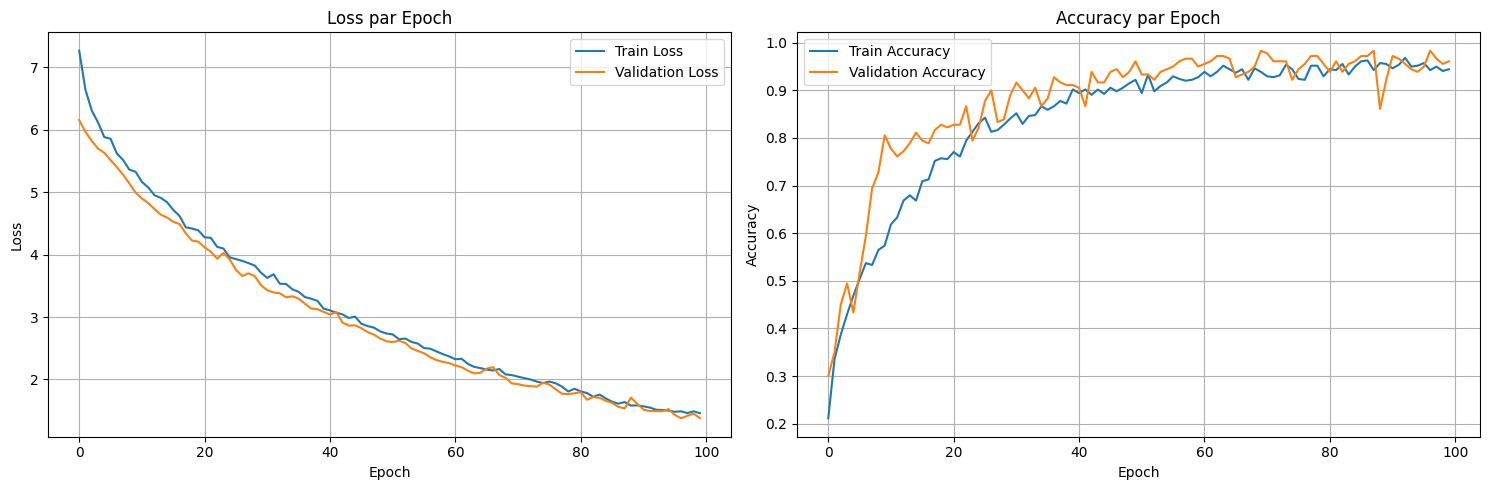


=== MÉTRIQUES FINALES ===
Train Accuracy: 0.9444
Validation Accuracy: 0.9611
Train Loss: 1.4608
Validation Loss: 1.3810
Écart Accuracy: 0.0167
Écart Loss: 0.0798

=== ÉVALUATION FINALE ===
Test Accuracy: 0.9833
Test Loss: 1.3671
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

=== RAPPORT DE CLASSIFICATION ===
                   precision    recall  f1-score   support

alternator_pulley       0.97      1.00      0.98        30
      belt_squeal       1.00      0.97      0.98        30
     exhaust_leak       1.00      0.97      0.98        30
         knocking       0.97      1.00      0.98        30
          normale       1.00      1.00      1.00        30
       water_pump       0.97      0.97      0.97        30

         accuracy                           0.98       180
        macro avg       0.98      0.98      0.98       180
     weighted avg       0.98      0.98      0.98       180


=== SAUVEGARDE ===
Modèle conservateur sauvegardé avec succès!


In [30]:
# Script principal modifié
def main_conservative():
    print("=== CHARGEMENT CONSERVATEUR DES DONNÉES ===")
    # Limiter les échantillons par classe pour réduire l'overfitting
    X, labels, file_paths = load_and_preprocess_data_conservative(
        config.INPUT_DIR, 
        use_augmentation=True,
        max_samples_per_class=50  # Limiter à 50 échantillons max par classe
    )
    
    # Ajout de la dimension channel
    X = X[..., np.newaxis]
    
    print(f"\nDonnées chargées:")
    print(f"- Shape des features: {X.shape}")
    print(f"- Nombre d'échantillons: {len(labels)}")
    
    # Encodage des labels
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    
    print(f"- Classes: {encoder.classes_}")
    print(f"- Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for class_name, count in zip(unique, counts):
        print(f"  * {class_name}: {count} échantillons")
    
    # Division stratifiée avec validation séparée
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2 du total
    )
    
    print(f"\nDivision des données:")
    print(f"- Train: {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"- Validation: {X_val.shape[0]} échantillons ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"- Test: {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Création du modèle régularisé
    print("\n=== CRÉATION DU MODÈLE RÉGULARISÉ ===")
    model = create_regularized_model(X.shape[1:], len(encoder.classes_))
    model.summary()
    
    # Entraînement strict
    print("\n=== ENTRAÎNEMENT STRICT ===")
    history = train_with_strict_early_stopping(model, X_train, y_train, X_val, y_val)
    
    # Visualisation de l'entraînement
    print("\n=== ANALYSE DE L'ENTRAÎNEMENT ===")
    plot_training_history(history)
    
    # Évaluation finale sur test
    print("\n=== ÉVALUATION FINALE ===")

    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Prédictions détaillées
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print("\n=== RAPPORT DE CLASSIFICATION ===")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=encoder.classes_))
    
    # Sauvegarde
    print("\n=== SAUVEGARDE ===")
    model.save(os.path.join(config.WORKING_DIR, 'conservative_model.h5'))
    joblib.dump(encoder, os.path.join(config.WORKING_DIR, 'conservative_encoder.joblib'))
    
    print("Modèle conservateur sauvegardé avec succès!")
    
    return model, encoder, history

if __name__ == "__main__":
    model, encoder, history = main_conservative()

# **10. Script de Test**

In [45]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import joblib

class Config:
    # Configuration alignée avec votre modèle conservateur
    TARGET_LENGTH = 3  # 3 secondes comme dans votre modèle
    SR = 16000  # Sample rate réduit
    N_MFCC = 13  
    HOP_LENGTH = 512 
    N_FFT = 1024  # N_FFT réduit
    N_MELS = 64  # Pour cohérence avec votre modèle

config = Config()

def load_model_and_encoder():
    """Charge le modèle et l'encodeur sauvegardés"""
    model_path = os.path.join("/kaggle/working/", 'conservative_model.h5')
    encoder_path = os.path.join("/kaggle/working/", 'conservative_encoder.joblib')
    
    if not os.path.exists(model_path) or not os.path.exists(encoder_path):
        raise FileNotFoundError("Les fichiers du modèle ou de l'encodeur sont introuvables")
    
    model = tf.keras.models.load_model(model_path)
    encoder = joblib.load(encoder_path)
    
    return model, encoder

def preprocess_audio(file_path):
    """Prétraite un fichier audio pour la prédiction selon la configuration conservatrice"""
    # Chargement de l'audio
    y, sr = librosa.load(file_path, sr=config.SR)
    y = librosa.util.normalize(y)
    
    # Découpage/padding pour longueur fixe
    target_samples = config.TARGET_LENGTH * config.SR
    if len(y) > target_samples:
        start = (len(y) - target_samples) // 2
        y = y[start:start + target_samples]
    else:
        y = np.pad(y, (0, max(0, target_samples - len(y))))
    
    y = y[:target_samples]
    
    # Extraction des MFCC (simplifiée comme dans votre modèle)
    mfcc = librosa.feature.mfcc(
        y=y, 
        sr=config.SR, 
        n_mfcc=config.N_MFCC,
        hop_length=config.HOP_LENGTH,
        n_fft=config.N_FFT
    )
    
    # Ajout seulement du delta (pas delta-delta comme dans votre modèle conservateur)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_combined = np.concatenate([mfcc, mfcc_delta], axis=0)
    
    # Standardisation des dimensions temporelles
    expected_time_steps = int(np.ceil(target_samples / config.HOP_LENGTH))
    if mfcc_combined.shape[1] > expected_time_steps:
        mfcc_combined = mfcc_combined[:, :expected_time_steps]
    elif mfcc_combined.shape[1] < expected_time_steps:
        pad_width = expected_time_steps - mfcc_combined.shape[1]
        mfcc_combined = np.pad(mfcc_combined, ((0, 0), (0, pad_width)), 'constant')
    
    # Ajout des dimensions pour le modèle (batch, time, features, channel)
    mfcc_combined = mfcc_combined.T[np.newaxis, ..., np.newaxis]
    
    return mfcc_combined

def predict_audio(file_path, model, encoder):
    """Effectue une prédiction sur un fichier audio"""
    # Prétraitement
    features = preprocess_audio(file_path)
    
    # Prédiction
    predictions = model.predict(features)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = encoder.inverse_transform([predicted_class_idx])[0]
    confidence = np.max(predictions) * 100
    
    # Récupération des probabilités pour toutes les classes
    class_probabilities = {
        class_name: float(prob) * 100 
        for class_name, prob in zip(encoder.classes_, predictions[0])
    }
    
    return predicted_class, confidence, class_probabilities

def get_class_descriptions():
    """Retourne les descriptions des classes"""
    return {
        'normale': 'Fonctionnement normal du moteur sans anomalie détectable',
        'belt_squeal': 'Grincement de courroie - usure ou tension incorrecte',
        'knocking': 'Cliquetis moteur - combustion anormale, risque grave',
        'alternator_pulley': 'Défaut poulie alternateur - problème électrique',
        'exhaust_leak': 'Fuite échappement - performance et émissions affectées',
        'water_pump': 'Défaut pompe à eau - risque surchauffe moteur'
    }

def test_audio_file(file_path):
    """Fonction principale pour tester un fichier audio"""
    # Chargement du modèle et de l'encodeur
    model, encoder = load_model_and_encoder()
    
    # Vérification que le fichier existe
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Le fichier {file_path} n'existe pas")
    
    # Prédiction
    predicted_class, confidence, class_probs = predict_audio(file_path, model, encoder)
    descriptions = get_class_descriptions()
    
    # Affichage des résultats
    print("\n=== RÉSULTATS DE LA PRÉDICTION ===")
    print(f"Fichier audio testé: {os.path.basename(file_path)}")
    print(f"\nClasse prédite: {predicted_class} ({confidence:.2f}% de confiance)")
    print(f"Description: {descriptions.get(predicted_class, 'Pas de description disponible')}")
    
    print("\nDétail des probabilités par classe:")
    for class_name, prob in sorted(class_probs.items(), key=lambda x: x[1], reverse=True):
        print(f"- {class_name}: {prob:.2f}%")
    
    return predicted_class, confidence, class_probs

# Exemple d'utilisation
if __name__ == "__main__":
    # Chemin vers un fichier audio à tester (à adapter)
    test_file = "/kaggle/input/audios3/audios/exhaust_leak/exhaust_leak_17.wav"  # Exemple de chemin local
    test_file = "/kaggle/input/audios3/audios/knocking/knocking_11.wav"
    test_file = "/kaggle/input/audios3/audios/water_pump/water_pump_2.wav"
    
    try:
        predicted_class, confidence, class_probs = test_audio_file(test_file)
    except Exception as e:
        print(f"Erreur lors du test: {str(e)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step

=== RÉSULTATS DE LA PRÉDICTION ===
Fichier audio testé: water_pump_2.wav

Classe prédite: water_pump (99.95% de confiance)
Description: Défaut pompe à eau - risque surchauffe moteur

Détail des probabilités par classe:
- water_pump: 99.95%
- alternator_pulley: 0.03%
- exhaust_leak: 0.01%
- knocking: 0.01%
- normale: 0.00%
- belt_squeal: 0.00%
